In [2]:
#Importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2

#For task 5:
from scipy.special import erfc



In [3]:
#Task 1 : Loading image and generate 8-bit PCM bitstream
img = cv2.imread("cameraman.png",cv2.IMREAD_GRAYSCALE)
M, N = img.shape    #returns (rows,columns) = (M,N)
x = img/255         #normalize pixel values to [0,1]
x_vec = x.flatten() #2D matrix to 1D sequence of symbols

#pcm_encoding
#b = 8
#L = 256

def pcm_encode(x,b):
    
    L = 2**b
    delta = 1/L  #step size
    k = np.floor(x/delta)
    k = np.clip(k,0,L-1).astype(int)
    xcap = (k + 0.5)*delta

    Ps = np.mean(x**2)         #signal power
    Pn = np.mean((x-xcap)**2)  #noise power
    SQNR_dB = 10 * np.log10(Ps/Pn) #SNR calculation

    bitstream = ""
    for v in k:
        bitstream += np.binary_repr(int(v),width = 8)
    b_tx = np.array(list(bitstream),dtype = np.uint8)
    return k, xcap, b_tx, bitstream

b = 8
b_tx = pcm_encode(x_vec, b)[2]
print(b_tx)


[1 0 0 ... 0 0 1]


c:\Users\alanf\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\alanf\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\collections.py:197: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


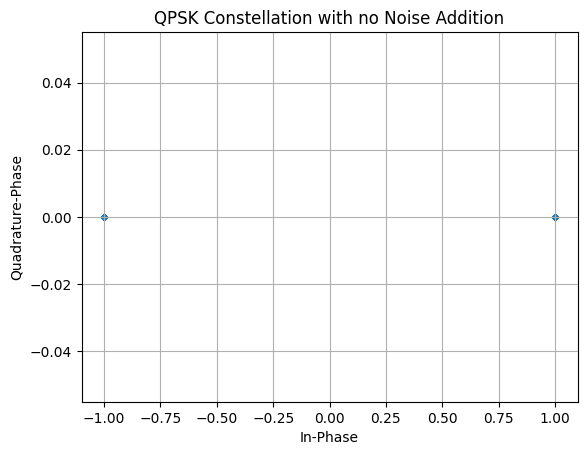

[[1 0]
 [0 1]
 [1 1]
 ...
 [1 1]
 [0 0]
 [0 1]]


In [4]:
#Task 2 : BPSK Modulation and Constellation

#now from b_tx we map bits to BPSK Symbols
#generate BPSK Modulated signal
#plot constellation graph

Eb = 1
bits_reshaped = b_tx.reshape(-1, 2)
    
    # Gray mapping [cite: 41-44, 131]
    # 00 -> 1+j, 01 -> -1+j, 11 -> -1-j, 10 -> 1-j
mapping = {
    (0,0):  1 + 1j,
    (0,1): -1 + 1j,
    (1,1): -1 - 1j,
    (1,0):  1 - 1j
}
s = np.array([mapping[tuple(b)] for b in bits_reshaped]) * np.sqrt(Eb)

plt.figure()
plt.scatter(s,np.zeros_like(s),s=10)
plt.xlabel("In-Phase")
plt.ylabel("Quadrature-Phase")
plt.title("QPSK Constellation with no Noise Addition")
plt.grid()
plt.show()
print(bits_reshaped)

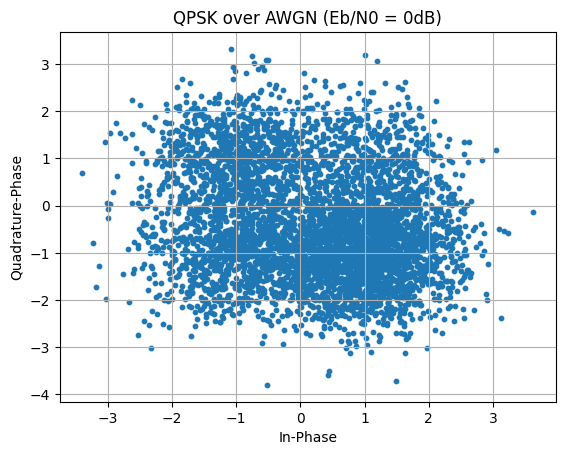

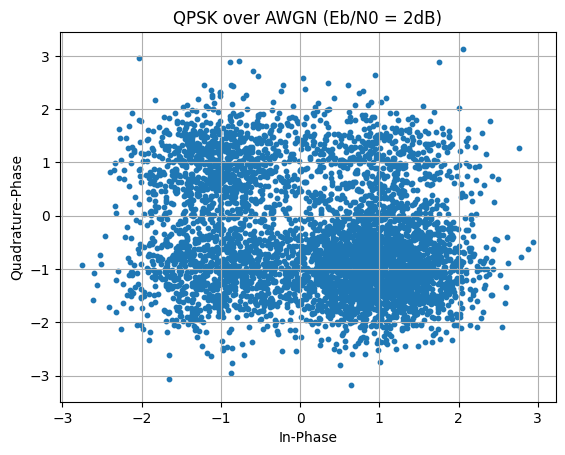

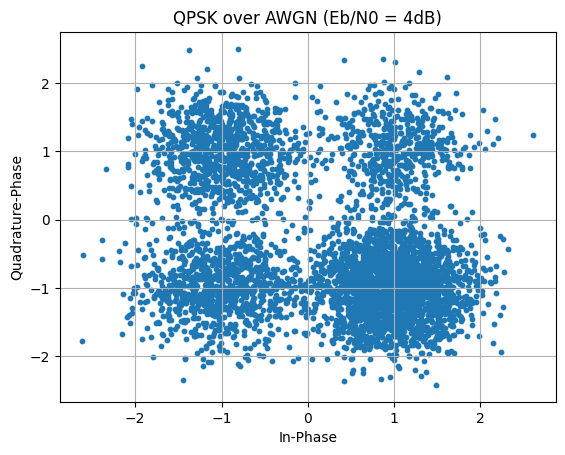

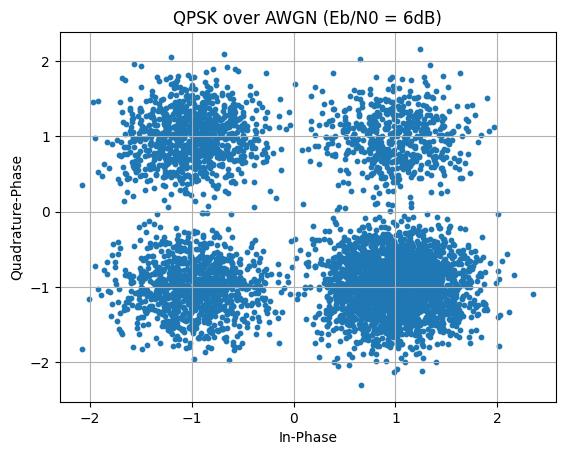

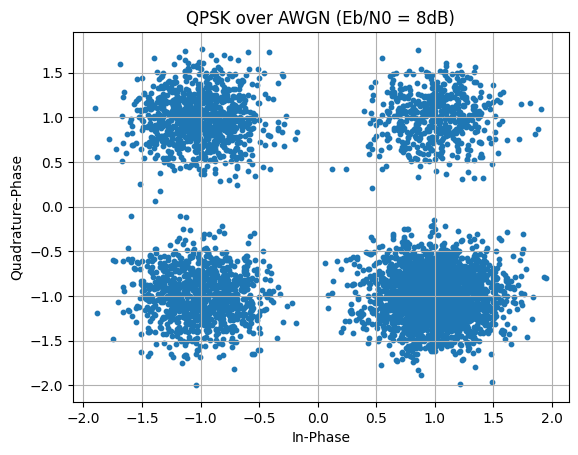

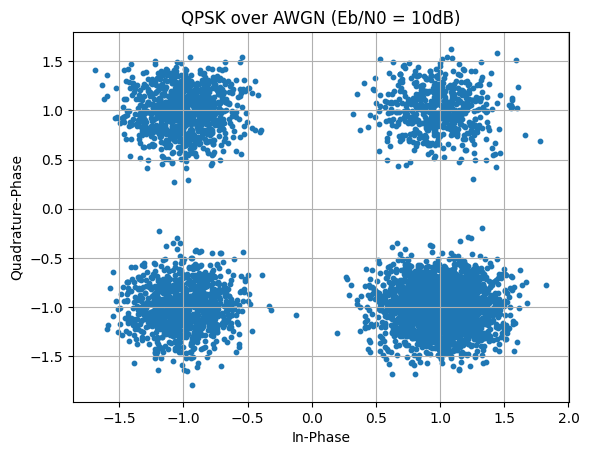

In [5]:
#Task 3 : AWGN Channel simulation (complex basebad) for multiple Eb/N0 values
#Eb/N0 in dB = [0,2,4,6,8,10]
#add complex AWGN
#observe spreading in I-Q plane

list_y = []  #list of received signals

Eb = 1
EbN0_dB = np.arange(0,11,2) # 0,2,4,6,8,10
EbN0_lin = 10 ** (EbN0_dB/10)

for i in range(len(EbN0_lin)):
    N0 = Eb/EbN0_lin[i]
    noise_variance = N0/2

    nI = np.sqrt(noise_variance)*np.random.randn(len(s))   #in phase noise components
    nQ = np.sqrt(noise_variance)*np.random.randn(len(s))   #quadrature noise components
    n = nI + 1j*nQ

    y = s + n      #total signal
    list_y.append(y)


#For each Eb/N0 produce scatter plot of received symbols

for i in range(len(EbN0_dB)):
    plt.figure()
    plt.scatter(np.real(list_y[i][:5000]), np.imag(list_y[i][:5000]),s=10)
    plt.xlabel("In-Phase")
    plt.ylabel("Quadrature-Phase")
    plt.title(f"QPSK over AWGN (Eb/N0 = {EbN0_dB[i]}dB)")
    plt.grid()
    plt.show()

Eb/N0 = 0 dB : BER = 0.078859
Eb/N0 = 2 dB : BER = 0.037743
Eb/N0 = 4 dB : BER = 0.012312
Eb/N0 = 6 dB : BER = 0.002367
Eb/N0 = 8 dB : BER = 0.000208
Eb/N0 = 10 dB : BER = 0.000002


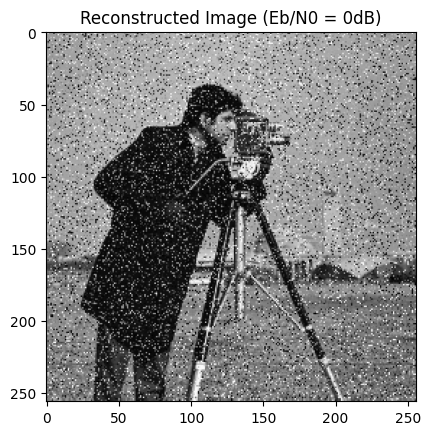

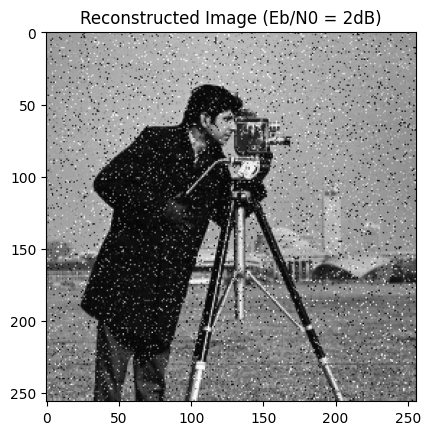

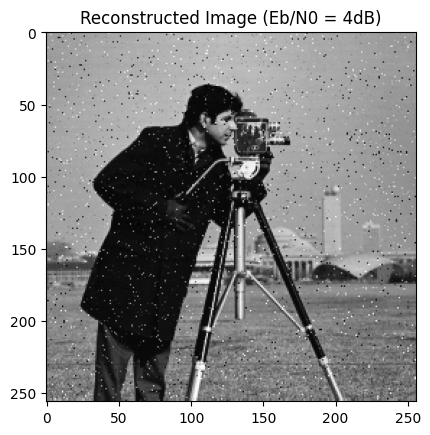

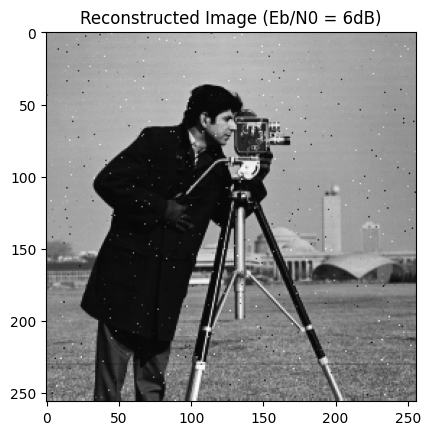

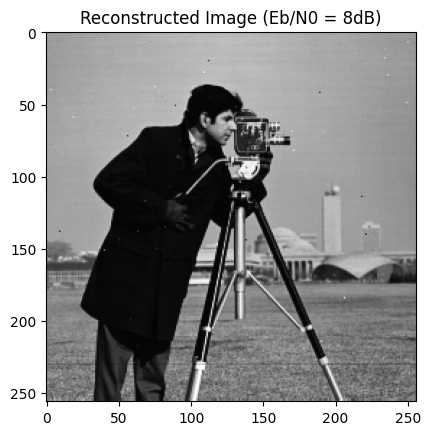

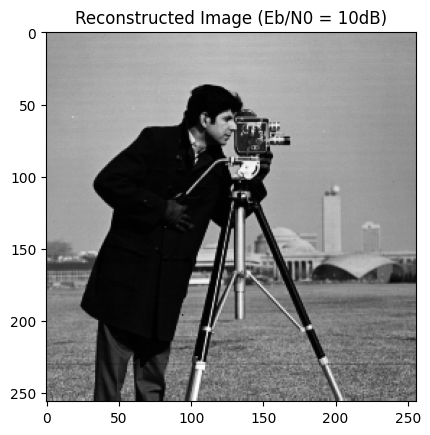

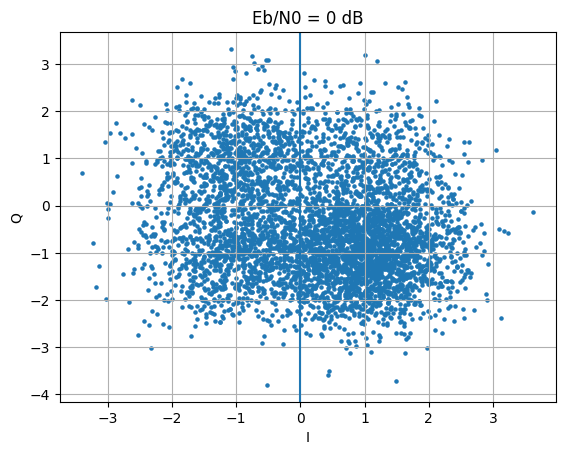

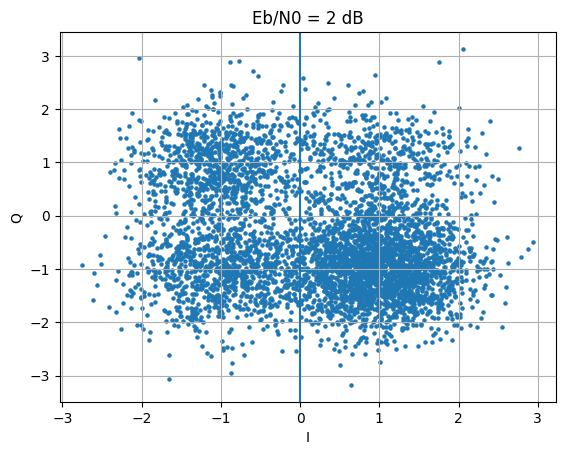

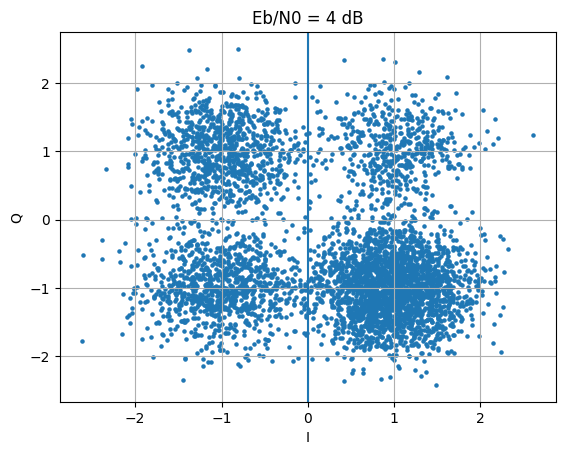

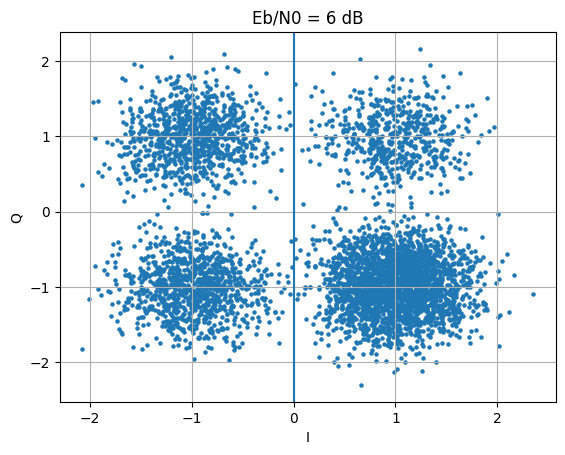

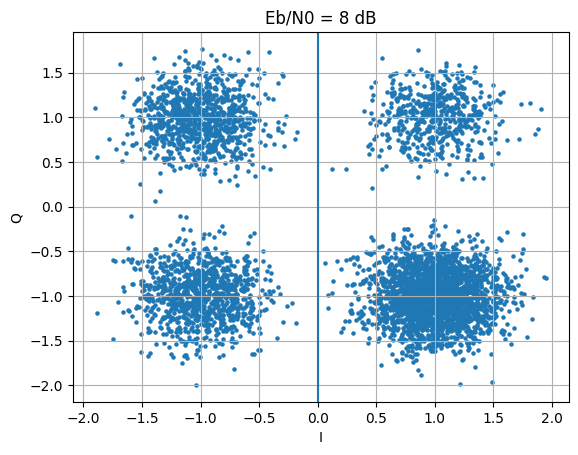

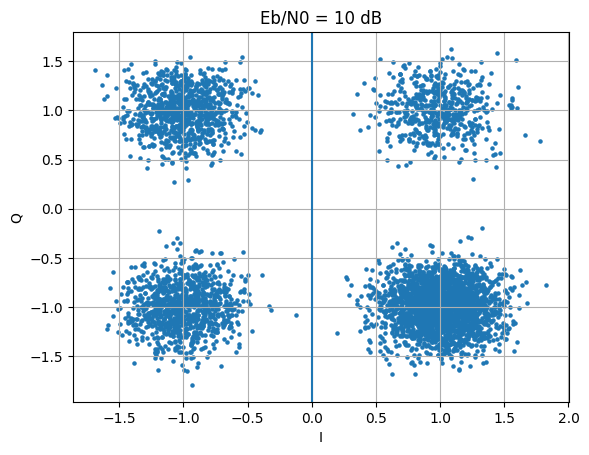

In [6]:
sim_BER = []
list_b_rx=[]

for i in range(len(EbN0_dB)):
    received_signal = list_y[i]
    

    detected_bits = np.zeros((len(received_signal), 2), dtype=int)
    
    # Decode MSB (Bit 0) from Imaginary part
    detected_bits[:, 0] = np.where(np.imag(received_signal) > 0, 0, 1)
    
    # Decode LSB (Bit 1) from Real part
    detected_bits[:, 1] = np.where(np.real(received_signal) > 0, 0, 1)
    
    # --- BER Calculation ---
    # Flatten to match original bitstream shape
    rx_bits = detected_bits.flatten()
    tx_bits = b_tx # The original transmitted bits
    
    # Count errors
    errors = np.sum(rx_bits != tx_bits)
    ber = errors / len(tx_bits)
    list_b_rx.append(rx_bits)
    sim_BER.append(ber)

sim_BER = np.array(sim_BER)

def pcm_decode(b_rx, b, M, N):
    L = 2**b
    delta = 1 / L
    total_bits = (len(b_rx) // b) * b
    b_rx = b_rx[:total_bits] #drops extra bits caused by channel truncation
    bits = b_rx.reshape(-1, b) #each row is one symbol

    #converting binary number into a digit in decimal rep
    k_hat = []
    for row in bits:
        binary_string = ""
        for bit in row:
            binary_string += str(bit)
        index = int(binary_string, 2)
        k_hat.append(index)

    #mid-rise reconstruction    
    k_hat = np.array(k_hat)
    k_hat = np.clip(k_hat, 0, L-1)
    xcap = (k_hat + 0.5) * delta
    xcap_img = xcap.reshape(M, N)

    return xcap_img
    
#reconstructed images:
reconstructed_images = []
for i in range(len(EbN0_dB)):
    img_hat = pcm_decode(list_b_rx[i],b,M,N)
    reconstructed_images.append(img_hat)

#saving and attaching BER, reconstructed images, I-Q scatter plot
for i in range(len(EbN0_dB)):
    print(f"Eb/N0 = {EbN0_dB[i]} dB : BER = {sim_BER[i]:.6f}")

#reconstructed image plot
for i in range(len(EbN0_dB)):
    plt.figure()
    plt.imshow(reconstructed_images[i],cmap='gray')
    plt.title(f"Reconstructed Image (Eb/N0 = {EbN0_dB[i]}dB)")
    plt.show()

#I vs Q scatter plot


for i in range(len(EbN0_dB)):
    plt.figure()
    y = list_y[i]
    plt.scatter(np.real(y[:5000]),np.imag(y[:5000]), s=5)

    # ML decision boundary
    plt.axvline(0)

    plt.title(f"Eb/N0 = {EbN0_dB[i]} dB")
    plt.xlabel("I")
    plt.ylabel("Q")
    plt.grid()

plt.show()


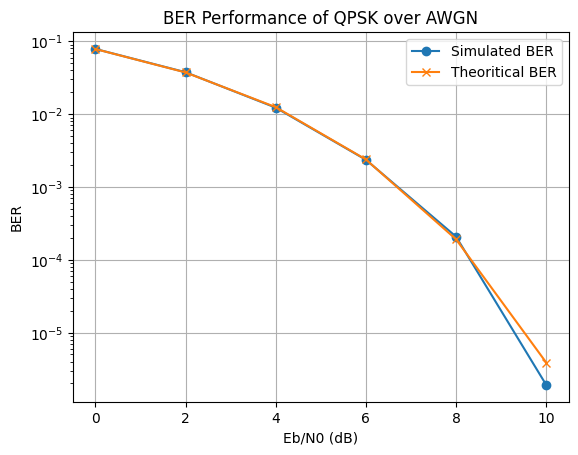

In [7]:
#Task 5 : Theoritical BER and comparison with simulated values

theoritical_BER = 0.5 * erfc(np.sqrt(EbN0_lin))

#semilog plot
plt.figure()
plt.semilogy(EbN0_dB,sim_BER,'-o',label = 'Simulated BER')
plt.semilogy(EbN0_dB,theoritical_BER,'-x',label = 'Theoritical BER')
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")
plt.title("BER Performance of QPSK over AWGN")
plt.legend()
plt.grid()
plt.show()